# 1. Подключение библиотек и создание SparkSession

In [1]:
import os
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick
from pyspark.sql.functions import min, max, mean, stddev
from pyspark.sql.functions import dayofweek
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns


conf = (
    SparkConf()
    .setAppName("SOBD_Lab1_Local_Taxi")
    .setMaster("local[6]")                    # использовать 6 ядер Ryzen
    .set("spark.driver.memory", "10g")        # немного меньше общей памяти
    .set("spark.executor.memory", "10g")
    .set("spark.memory.fraction", "0.8")      # 80% под вычисления, 20% под кеш
    .set("spark.memory.storageFraction", "0.3")
    .set("spark.sql.shuffle.partitions", "80")   # меньше партиций → меньше накладных расходов
    .set("spark.default.parallelism", "80")
    .set("spark.sql.execution.arrow.pyspark.enabled", "true")
    .set("spark.sql.execution.arrow.maxRecordsPerBatch", "500000")
    .set("spark.sql.broadcastTimeout", "36000")
    .set("spark.local.dir", "/tmp/spark-temp")
    .set("spark.ui.showConsoleProgress", "true")
)

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

In [6]:
!free -h
!nproc

               total        used        free      shared  buff/cache   available
Mem:            11Gi       3.4Gi       7.5Gi       3.0Mi       864Mi       8.2Gi
Swap:          8.0Gi          0B       8.0Gi
6


# 2. Загрузка очищенных данных из Parquet

In [2]:
# Путь к очищенным данным
path_clean = "/home/jovyan/work/data/clean_taxi_data2.parquet"

# Чтение parquet-файла
df = spark.read.parquet(path_clean)

print("Данные успешно загружены.")
print(f"Количество строк: {df.count():,}")
df.printSchema()
df.limit(5).toPandas()

Данные успешно загружены.
Количество строк: 99,343,130
root
 |-- vendorid: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- dolocationid: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: double (nullable = true)



,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2018-01-01 02:49:29,2018-01-01 03:07:24,1,4.78,1,N,79,163,1,18.0,0.5,0.5,3.86,0,0.3,23.16
1,2,2018-01-01 02:08:46,2018-01-01 02:15:51,2,1.10,1,N,79,137,1,6.5,0.5,0.5,1.17,0,0.3,8.97
2,2,2018-01-01 02:30:09,2018-01-01 02:46:29,2,1.75,1,N,107,186,1,11.5,0.5,0.5,0.00,0,0.3,12.80
3,2,2018-01-01 02:50:59,2018-01-01 03:07:12,2,3.46,1,N,100,263,2,14.5,0.5,0.5,0.00,0,0.3,15.80
4,1,2018-01-01 02:19:57,2018-01-01 02:34:44,1,2.60,1,N,141,43,1,12.0,0.5,0.5,2.65,0,0.3,15.95


# 3. Проверка диапазона и базовая статистика

In [3]:
df.select(
    F.min("tpep_pickup_datetime").alias("min_pickup"), # Период поездок (от и до)
    F.max("tpep_dropoff_datetime").alias("max_dropoff"),
    F.mean("trip_distance").alias("avg_distance"), # Средняя длина поездки
    F.stddev("trip_distance").alias("std_distance"), # Насколько длина поездок сильно варьируется
    F.mean("fare_amount").alias("avg_fare"), # Средняя стоимость поездки (без чаевых)
    F.mean("tip_amount").alias("avg_tip"), # Средняя сумма чаевых
    F.mean("total_amount").alias("avg_total") # Средняя общая сумма поездки
).show(truncate=False)

+-------------------+-------------------+-----------------+------------------+-----------------+------------------+------------------+
|min_pickup         |max_dropoff        |avg_distance     |std_distance      |avg_fare         |avg_tip           |avg_total         |
+-------------------+-------------------+-----------------+------------------+-----------------+------------------+------------------+
|2001-01-01 00:01:48|2084-11-04 12:47:41|1.789036107076592|1.2325591775772617|9.865661163786536|1.4255334389002372|12.436880913026751|
+-------------------+-------------------+-----------------+------------------+-----------------+------------------+------------------+



# 4. Распределение поездок по часам суток

In [21]:
df_hours = (
    df.withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))
      .groupBy("pickup_hour")
      .count()
      .orderBy("pickup_hour")
)
df_hours.show(truncate=False)

print("Количество строк:", df_hours.count())

+-----------+-------+
|pickup_hour|count  |
+-----------+-------+
|0          |3000597|
|1          |2113193|
|2          |1513320|
|3          |1072054|
|4          |774647 |
|5          |853354 |
|6          |2182279|
|7          |3739804|
|8          |4663709|
|9          |4736771|
|10         |4702958|
|11         |4900715|
|12         |5175814|
|13         |5184433|
|14         |5384179|
|15         |5381282|
|16         |4990239|
|17         |5760050|
|18         |6522469|
|19         |6266633|
+-----------+-------+
only showing top 20 rows

Количество строк: 24


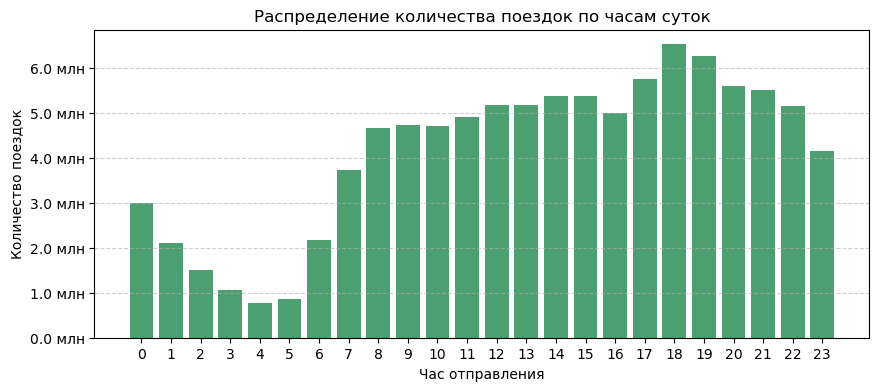

In [5]:
# Тут Spark обрабатывает весь набор 
# но возвращает только 24 строки (по количеству часов в сутках)
data = df_hours.collect()

# Преобразуем в обычный список для построения графика 
hours = [row["pickup_hour"] for row in data]
counts = [row["count"] for row in data]

# Визуализация 
plt.figure(figsize=(10, 4))
plt.bar(hours, counts, color="#4C9F70")

plt.title("Распределение количества поездок по часам суток")
plt.xlabel("Час отправления")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f} млн'))
plt.xticks(range(0, 24))
plt.show()

## Распределение по дням недели

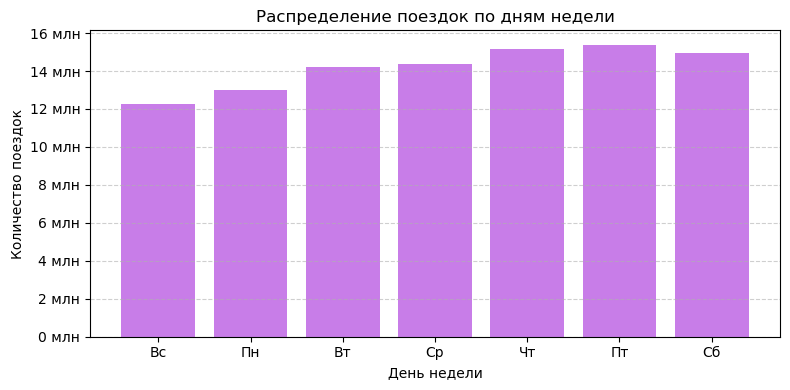

In [6]:
df_week = (
    df.withColumn("weekday", F.dayofweek("tpep_pickup_datetime"))
      .groupBy("weekday")
      .count()
      .orderBy("weekday")
)

# Получаем данные (всего 7 строк — безопасно)
rows = df_week.collect()

weekdays = [r["weekday"] for r in rows]
counts = [r["count"] for r in rows]

# Подписи дней недели (Spark format)
weekday_labels = ['Вс', 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб']

plt.figure(figsize=(8, 4))
plt.bar(weekdays, counts, color="#c87de8")

plt.title("Распределение поездок по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество поездок")

plt.xticks(ticks=range(1, 8), labels=weekday_labels)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x/1e6:.0f} млн'))

plt.tight_layout()
plt.show()

## Распределение по месяцам

In [7]:
from pyspark.sql.functions import min, max

df.select(
    min("tpep_pickup_datetime").alias("min_date"),
    max("tpep_pickup_datetime").alias("max_date")
).show(truncate=False)

+-------------------+-------------------+
|min_date           |max_date           |
+-------------------+-------------------+
|2001-01-01 00:01:48|2084-11-04 12:32:24|
+-------------------+-------------------+



In [5]:
from pyspark.sql import functions as F

df_years = df.withColumn("year", F.year("tpep_pickup_datetime"))
df_years.groupBy("year").count().orderBy("year").show(200, truncate=False)

+----+--------+
|year|count   |
+----+--------+
|2001|14      |
|2002|19      |
|2003|9       |
|2008|299     |
|2009|474     |
|2017|196     |
|2018|99341918|
|2019|160     |
|2020|15      |
|2026|2       |
|2029|1       |
|2031|2       |
|2037|2       |
|2041|1       |
|2042|2       |
|2084|16      |
+----+--------+



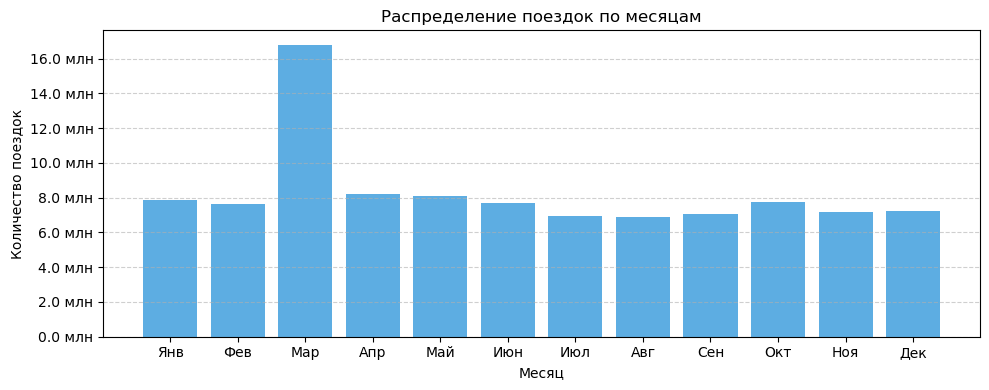

In [10]:
# Группировка по месяцам
df_months = (
    df.withColumn("month", F.month("tpep_pickup_datetime"))
      .groupBy("month")
      .agg(F.count("*").alias("count"))
      .orderBy("month")
)

# Сбор данных
rows = df_months.collect()

# Подготовка списков
months_num = [r["month"] for r in rows]
counts = [r["count"] for r in rows]

month_labels = ["Янв", "Фев", "Мар", "Апр", "Май", "Июн",
                "Июл", "Авг", "Сен", "Окт", "Ноя", "Дек"]

# Визуализация
plt.figure(figsize=(10, 4))
plt.bar(months_num, counts, color="#5DADE2")

plt.title("Распределение поездок по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество поездок")

plt.xticks(ticks=range(1, 13), labels=month_labels)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f} млн"))

plt.tight_layout()
plt.show()

In [11]:
df.select(F.month("tpep_pickup_datetime").alias("m")).groupBy("m").count().orderBy("m").show()

+---+--------+
|  m|   count|
+---+--------+
|  1| 7839717|
|  2| 7610356|
|  3|16787590|
|  4| 8232773|
|  5| 8106177|
|  6| 7665896|
|  7| 6917736|
|  8| 6896277|
|  9| 7078233|
| 10| 7767731|
| 11| 7199106|
| 12| 7241538|
+---+--------+



# 5. Анализ распределений числовых признаков (числовых столбцов)

## Общая статистика числовых столбцов
   ### trip_distance - Дистанция поездки (в милях).
   ### fare_amount - Сумма тарифа за поездку (без чаевых).
   ### tip_amount - Сумма чаевых.
   ### total_amount - Итоговая сумма к оплате (всё вместе).

In [12]:
numeric_cols = ["trip_distance", "fare_amount", "tip_amount", "total_amount"]

df.select(numeric_cols).describe().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|     trip_distance|      fare_amount|        tip_amount|      total_amount|
+-------+------------------+-----------------+------------------+------------------+
|  count|          99343130|         99343130|          99343130|          99343130|
|   mean| 1.789036107076592|9.865661163786536|1.4255334389002372|12.436880913026751|
| stddev|1.2325591775772617|6.011738072494903|1.6346019313402058| 6.989691833565827|
|    min|               0.0|             0.01|               0.0|              0.01|
|    max|              6.06|            499.0|             496.0|             499.8|
+-------+------------------+-----------------+------------------+------------------+



## Гистограммы распределений

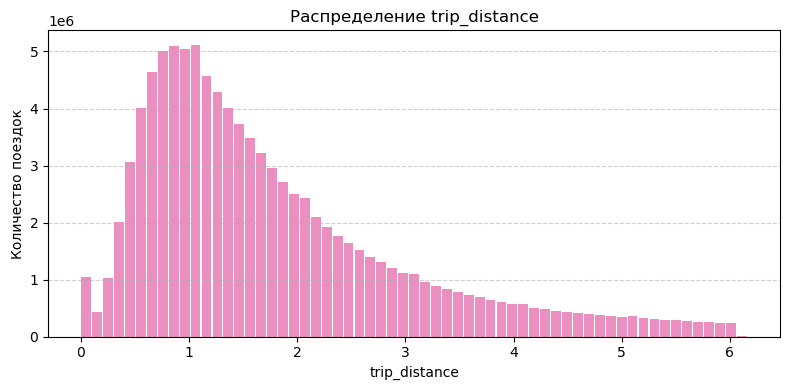

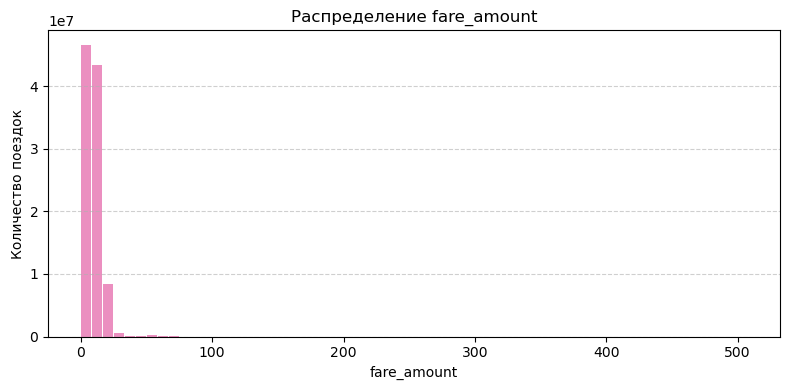

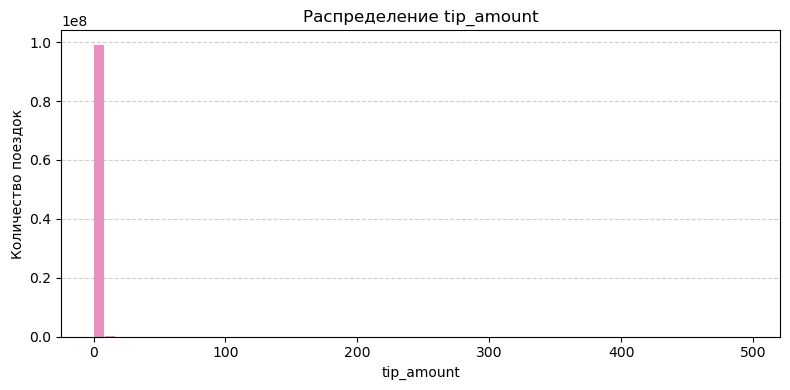

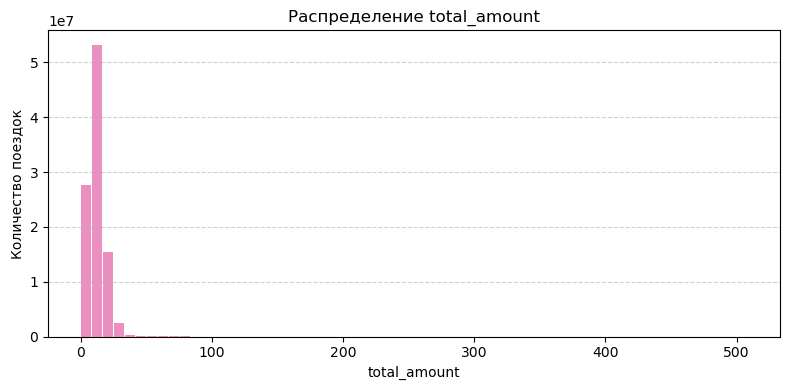

In [13]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

numeric_cols = ["trip_distance", "fare_amount", "tip_amount", "total_amount"]
num_bins = 60

# Приводим к double
for c in numeric_cols:
    df = df.withColumn(c, F.col(c).cast("double"))

for col in numeric_cols:

    # min и max
    min_val, max_val = df.select(
        F.min(col),
        F.max(col)
    ).first()

    if min_val is None or max_val is None or min_val == max_val:
        print(f"Пропускаю {col} — пустой или постоянный столбец")
        continue
    
    step = (max_val - min_val) / num_bins

    # вычисление бинов
    hist_df = (
        df
        .filter(F.col(col).isNotNull())
        .withColumn(
            "bin",
            F.when(
                (F.col(col) >= min_val) & (F.col(col) <= max_val),
                ((F.col(col) - min_val) / step).cast("int")
            )
        )
        .filter(F.col("bin").isNotNull())
        .groupBy("bin")
        .count()
        .orderBy("bin")
    )

    rows = hist_df.collect()

    # центры корзин
    bin_centers = [min_val + (b + 0.5) * step for b in [r["bin"] for r in rows]]
    counts = [r["count"] for r in rows]

    # график
    plt.figure(figsize=(8, 4))
    plt.bar(bin_centers, counts, width=step * 0.9,
            color="#E87CB5", alpha=0.85)

    plt.title(f"Распределение {col}")
    plt.xlabel(col)
    plt.ylabel("Количество поездок")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

## Корреляции между числовыми признаками

In [4]:
type(df)

pyspark.sql.dataframe.DataFrame

In [7]:
df.select("trip_distance", "fare_amount", "tip_amount", "total_amount").limit(10).toPandas()

,trip_distance,fare_amount,tip_amount,total_amount
0,4.78,18.0,3.86,23.16
1,1.10,6.5,1.17,8.97
2,1.75,11.5,0.00,12.80
3,3.46,14.5,0.00,15.80
4,2.60,12.0,2.65,15.95
5,2.70,14.5,0.00,15.80
6,5.70,19.5,4.00,24.80
7,5.70,20.5,5.50,33.06
8,1.20,6.5,0.00,7.80
9,0.70,5.5,0.50,7.30


In [17]:
cols = ["trip_distance", "fare_amount", "tip_amount", "total_amount"]
corr_matrix = []

# Считаем корреляции методом Spark
for c1 in cols:
    row = []
    for c2 in cols:
        corr = df.stat.corr(c1, c2)
        row.append(corr)
        print(f"Корреляция {c1} ↔ {c2}: {corr:.3f}")
    corr_matrix.append(row)

corr_matrix = np.array(corr_matrix)  # преобразуем в матрицу для imshow

Корреляция trip_distance ↔ trip_distance: 1.000
Корреляция trip_distance ↔ fare_amount: 0.647
Корреляция trip_distance ↔ tip_amount: 0.311
Корреляция trip_distance ↔ total_amount: 0.635
Корреляция fare_amount ↔ trip_distance: 0.647
Корреляция fare_amount ↔ fare_amount: 1.000
Корреляция fare_amount ↔ tip_amount: 0.420
Корреляция fare_amount ↔ total_amount: 0.972
Корреляция tip_amount ↔ trip_distance: 0.311
Корреляция tip_amount ↔ fare_amount: 0.420
Корреляция tip_amount ↔ tip_amount: 1.000
Корреляция tip_amount ↔ total_amount: 0.607
Корреляция total_amount ↔ trip_distance: 0.635
Корреляция total_amount ↔ fare_amount: 0.972
Корреляция total_amount ↔ tip_amount: 0.607
Корреляция total_amount ↔ total_amount: 1.000


## Корреляции — тепловая карта

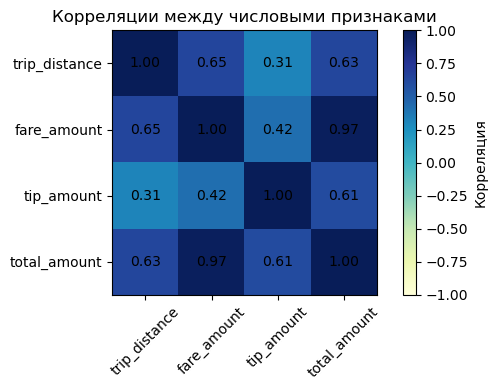

In [18]:
# Тепловая карта matplotlib
plt.figure(figsize=(6, 4))
plt.imshow(corr_matrix, cmap="YlGnBu", vmin=-1, vmax=1)
plt.colorbar(label="Корреляция")

# подписи осей
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=45)
plt.yticks(ticks=range(len(cols)), labels=cols)

# вывод значений внутри клеток
for i in range(len(cols)):
    for j in range(len(cols)):
        val = corr_matrix[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")

plt.title("Корреляции между числовыми признаками")
plt.tight_layout()
plt.show()

# 6. Анализ отдельных признаков

## 6.1 Анализ признака trip_distance

In [19]:
# Базовая статистика
df.select("trip_distance").describe().show()

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|          99343130|
|   mean| 1.789036107076592|
| stddev|1.2325591775772617|
|    min|               0.0|
|    max|              6.06|
+-------+------------------+



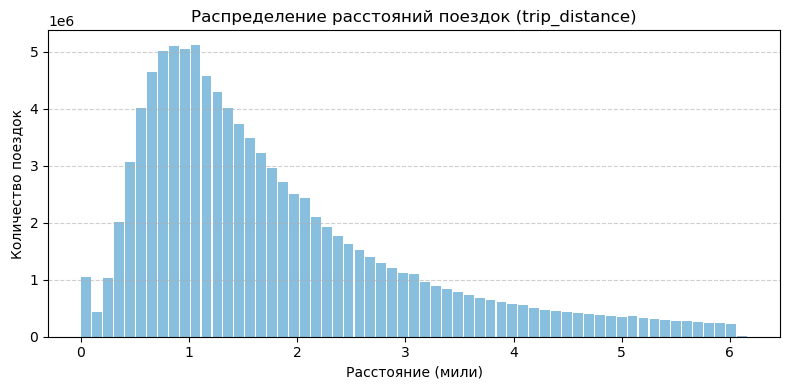

In [21]:
col = "trip_distance"
num_bins = 60

# Приведение к double
df = df.withColumn(col, F.col(col).cast("double"))

# Удаляем отрицательные значения и огромные выбросы (>50 миль)
df_clean = df.where((F.col(col) >= 0) & (F.col(col) <= 50))

# Находим min/max в очищенном столбце
min_val, max_val = df_clean.select(
    F.min(col),
    F.max(col)
).first()

if min_val is None or max_val is None or min_val == max_val:
    print(f"Столбец {col} пустой или константный, пропускаем.")
else:
    step = (max_val - min_val) / num_bins

    hist_df = (
        df_clean
        .withColumn("bin", ((F.col(col) - min_val) / step).cast("int"))
        .groupBy("bin")
        .agg(F.count("*").alias("count"))
        .orderBy("bin")
    )

    data = hist_df.collect()
    bin_centers = [(row["bin"] * step) + min_val + (step / 2) for row in data]
    counts = [row["count"] for row in data]

    plt.figure(figsize=(8, 4))
    plt.bar(bin_centers, counts, width=step * 0.9, color="#6BAED6", alpha=0.8)
    plt.title("Распределение расстояний поездок (trip_distance)")
    plt.xlabel("Расстояние (мили)")
    plt.ylabel("Количество поездок")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [26]:
# Приводим к double
df = df.withColumn("trip_distance", F.col("trip_distance").cast("double"))

# Квантили
q1, q2, q3 = df.approxQuantile("trip_distance", [0.25, 0.5, 0.75], 0.01)
iqr = q3 - q1

# используем max
import builtins
lower_bound = builtins.max(q1 - 1.5 * iqr, 0)
upper_bound = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}, Median = {q2:.2f}, Q3 = {q3:.2f}, IQR = {iqr:.2f}")
print(f"Допустимый диапазон: {lower_bound:.2f} – {upper_bound:.2f}")

df_clean = df.filter(
    (F.col("trip_distance") >= lower_bound) &
    (F.col("trip_distance") <= upper_bound)
)

print(f"Строк до очистки: {df.count():,}")
print(f"Строк после очистки: {df_clean.count():,}")

Q1 = 0.90, Median = 1.43, Q3 = 2.32, IQR = 1.42
Допустимый диапазон: 0.00 – 4.45
Строк до очистки: 99,343,130
Строк после очистки: 94,177,706


In [32]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import builtins  # чтобы не конфликтовать с pyspark.sql.functions.max/min


def plot_spark_boxplots(df, columns, sample_fraction: float = 0.05):
    box_data = []

    for column in columns:
        # Квантили
        q1, median, q3 = df.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        iqr = q3 - q1

        # Границы усов по правилу 1.5*IQR
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Реальные min/max
        min_v, max_v = df.select(F.min(col(column)), F.max(col(column))).first()

        # Безопасные усы
        lower_bound = builtins.max(lower_bound, min_v)
        upper_bound = builtins.min(upper_bound, max_v)

        #  Выборка выбросов (чтобы не собирать миллионы значений) 
        outliers_df = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
        outliers = [
            r[0]
            for r in (
                outliers_df
                .select(column)
                .sample(False, sample_fraction, seed=42)
                .limit(1000)
                .collect()
            )
        ]

        # Формируем структуру для bxp()
        box_data.append({
            "whislo":  lower_bound,
            "q1":      q1,
            "med":     median,
            "q3":      q3,
            "whishi":  upper_bound,
            "fliers":  outliers,
        })

        # Печать статистики
        print(f"\nСтатистика для {column}:")
        print(f"  Q1      = {q1:.2f}")
        print(f"  Median  = {median:.2f}")
        print(f"  Q3      = {q3:.2f}")
        print(f"  IQR     = {iqr:.2f}")
        print(f"  Нижняя граница (ус) = {lower_bound:.2f}")
        print(f"  Верхняя граница (ус) = {upper_bound:.2f}")
        print(f"  Min = {min_v:.2f}, Max = {max_v:.2f}")
        print(f"  Кол-во выбросов ≈ {len(outliers)}")

    # Построение боксплотов
    fig, ax = plt.subplots(figsize=(10, 1.5 + 0.8 * len(columns)))
    bp = ax.bxp(
        box_data,
        vert=False,
        positions=range(1, len(columns) + 1),
        widths=0.6,
        patch_artist=True
    )

    # Цвет коробок
    for box in bp['boxes']:
        box.set_facecolor("#6BAED6")
        box.set_alpha(0.8)

    # Настройки осей
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel("Значение")
    ax.set_title("Диаграмма размаха (Boxplot)")
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


Статистика для trip_distance:
  Q1      = 0.88
  Median  = 1.38
  Q3      = 2.13
  IQR     = 1.25
  Нижняя граница (ус) = 0.00
  Верхняя граница (ус) = 4.00
  Min = 0.00, Max = 4.44
  Кол-во выбросов ≈ 1000


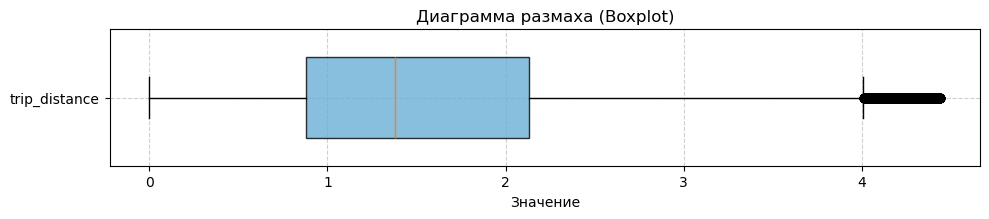

In [33]:
plot_spark_boxplots(df_clean, ["trip_distance"])

Распределение trip_distance имеет ярко выраженный правый хвост.

 Большинство поездок — короткие (до 3 миль).
 Встречаются редкие длинные поездки (до 50–60 миль).
 Boxplot подтверждает наличие выбросов в правой части распределения. 

25% поездок имели расстояние менее 1.1 миль,
медианное значение (Q2) составляет ~2.0 мили,
75% поездок не превышают 3.5 миль.
Таким образом, большая часть поездок — короткие, городские перемещения.
Межквартильный размах (IQR ≈ 2.4) подтверждает компактное распределение,
а значения свыше 7–8 миль можно считать редкими выбросами.

## 6.2 Анализ признака fare_amount

In [34]:
# Базовая статистика
df.select("fare_amount").describe().show()

+-------+-----------------+
|summary|      fare_amount|
+-------+-----------------+
|  count|         99343130|
|   mean|9.865661163786536|
| stddev|6.011738072494903|
|    min|             0.01|
|    max|            499.0|
+-------+-----------------+



In [35]:
# Преобразуем колонку в числовую
df = df.withColumn("fare_amount", F.col("fare_amount").cast("double"))

# Улучшенная точность квантилей
q1, q2, q3 = df.approxQuantile("fare_amount", [0.25, 0.5, 0.75], 0.01)

iqr = q3 - q1

# Границы выбросов (не допускаем отрицательные тарифы)
lower_bound = builtins.max(q1 - 1.5 * iqr, 0)
upper_bound = q3 + 1.5 * iqr

print(f"Q1 (25%): {q1:.2f}")
print(f"Q2 (медиана): {q2:.2f}")
print(f"Q3 (75%): {q3:.2f}")
print(f"IQR: {iqr:.2f}")
print(f"Диапазон нормальных значений: {lower_bound:.2f} – {upper_bound:.2f}")

Q1 (25%): 6.50
Q2 (медиана): 8.50
Q3 (75%): 12.50
IQR: 6.00
Диапазон нормальных значений: 0.00 – 21.50


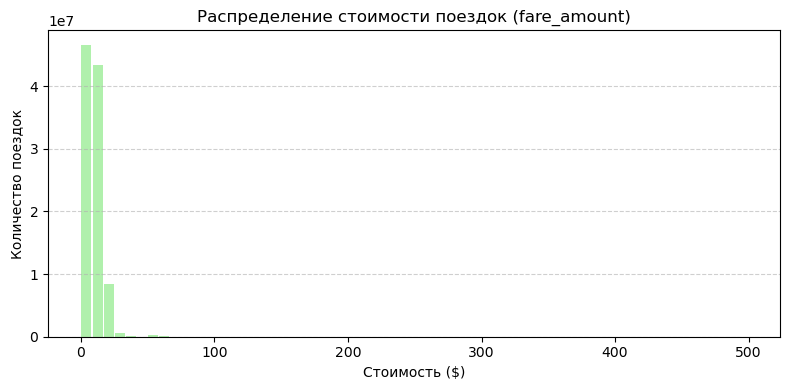

In [37]:
col_name = "fare_amount"
num_bins = 60

# Приведение к числу
df = df.withColumn(col_name, F.col(col_name).cast("double"))

# Находим min/max
min_val, max_val = df.select(
    F.min(col_name),
    F.max(col_name)
).first()

# Защита от мусора (fare_amount не может быть < 0)
min_val = builtins.max(min_val, 0)

# На случай, если столбец пустой или константный
if min_val is None or max_val is None or min_val == max_val:
    print("Столбец пустой или константный, гистограмму строить бессмысленно.")
else:
    step = (max_val - min_val) / num_bins

    # Spark-гистограмма
    hist_rows = (
        df.where(F.col(col_name).isNotNull())
          .withColumn("bin", ((F.col(col_name) - min_val) / step).cast("int"))
          .filter(F.col("bin") >= 0)           # невыходящие за диапазон
          .filter(F.col("bin") < num_bins)
          .groupBy("bin")
          .agg(F.count("*").alias("count"))
          .orderBy("bin")
          .collect()
    )

    # Преобразуем в обычные списки Python
    bins = [r["bin"] for r in hist_rows]
    counts = [r["count"] for r in hist_rows]
    bin_centers = [b * step + min_val + step / 2 for b in bins]

    # График
    plt.figure(figsize=(8, 4))
    plt.bar(bin_centers, counts, width=step * 0.9, color="#9ded97", alpha=0.8)
    plt.title("Распределение стоимости поездок (fare_amount)")
    plt.xlabel("Стоимость ($)")
    plt.ylabel("Количество поездок")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

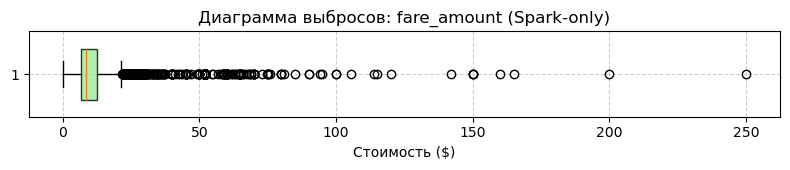


Статистика:
  Q1:       6.50
  Median:   8.50
  Q3:       12.50
  IQR:      6.00
  Lower:    0.00
  Upper:    21.50
  Min:      0.01
  Max:      499.00
  Кол-во выбросов (в выборке): 1000


In [39]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import builtins


def plot_fare_amount_boxplot(df):
    col_name = "fare_amount"

    # Приведение к числу
    df = df.withColumn(col_name, F.col(col_name).cast("double"))

    # Квантили
    q1, median, q3 = df.approxQuantile(col_name, [0.25, 0.5, 0.75], 0.01)
    iqr = q3 - q1

    # Границы по IQR
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Реальный min/max
    min_v, max_v = df.select(F.min(col_name), F.max(col_name)).first()

    # Защита от мусора (fare_amount не может быть < 0)
    lower_bound = builtins.max(lower_bound, 0)
    upper_bound = builtins.min(upper_bound, max_v)

    # Сэмплируем выбросы (иначе будут миллионы)
    outliers_df = df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))

    # Выборка max 1000 выбросов
    outliers = [
        r[0]
        for r in (
            outliers_df
            .select(col_name)
            .sample(False, 0.02, seed=42)
            .limit(1000)
            .collect()
        )
    ]

    # Структура для bxp()
    box_data = [{
        "whislo":  lower_bound,
        "q1":      q1,
        "med":     median,
        "q3":      q3,
        "whishi":  upper_bound,
        "fliers":  outliers,
    }]

    # Визуализация
    fig, ax = plt.subplots(figsize=(8, 1.8))
    bp = ax.bxp(
        box_data,
        vert=False,
        widths=0.6,
        patch_artist=True
    )

    # Цвет коробки
    for box in bp['boxes']:
        box.set_facecolor("#9ded97")
        box.set_alpha(0.8)

    ax.set_title("Диаграмма выбросов: fare_amount (Spark-only)")
    ax.set_xlabel("Стоимость ($)")
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

    print("\nСтатистика:")
    print(f"  Q1:       {q1:.2f}")
    print(f"  Median:   {median:.2f}")
    print(f"  Q3:       {q3:.2f}")
    print(f"  IQR:      {iqr:.2f}")
    print(f"  Lower:    {lower_bound:.2f}")
    print(f"  Upper:    {upper_bound:.2f}")
    print(f"  Min:      {min_v:.2f}")
    print(f"  Max:      {max_v:.2f}")
    print(f"  Кол-во выбросов (в выборке): {len(outliers)}")

# Вызов
plot_fare_amount_boxplot(df)

Q1 = 6.50, Median = 8.50, Q3 = 12.50, IQR = 6.00
Допустимый диапазон: 0.00 – 21.50
Строк до очистки: 99,343,130
Строк после очистки: 97,059,698


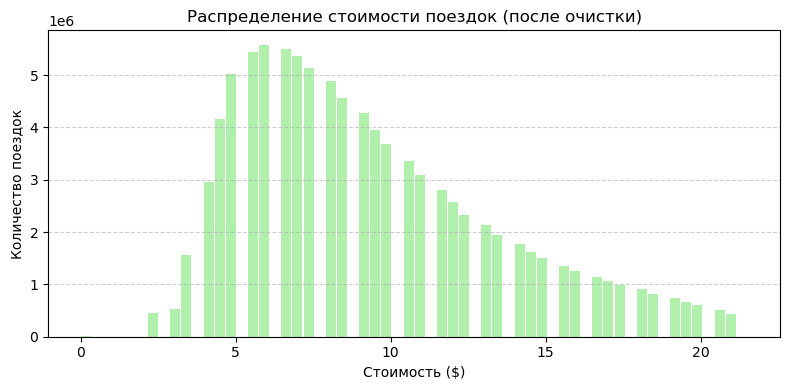

In [41]:
col = "fare_amount"
num_bins = 60

# Приведение типа
df = df.withColumn(col, F.col(col).cast("double"))

# Квантили
q1, q2, q3 = df.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)
iqr = q3 - q1

lower_bound = builtins.max(q1 - 1.5 * iqr, 0)    # защита от отрицательных тарифов
upper_bound = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}, Median = {q2:.2f}, Q3 = {q3:.2f}, IQR = {iqr:.2f}")
print(f"Допустимый диапазон: {lower_bound:.2f} – {upper_bound:.2f}")

# Очистка
df_fare_clean = df.filter(
    (F.col(col) >= lower_bound) &
    (F.col(col) <= upper_bound)
)

print(f"Строк до очистки: {df.count():,}")
print(f"Строк после очистки: {df_fare_clean.count():,}")

# глобальный min/max
min_val, max_val = df_fare_clean.select(
    F.min(col), F.max(col)
).first()

# Если столбец пустой или константный
if min_val is None or min_val == max_val:
    print("Столбец пустой или одинаковый — гистограмма невозможна.")
else:
    step = (max_val - min_val) / num_bins

    # гистограмма
    hist_rows = (
        df_fare_clean
        .where(F.col(col).isNotNull())
        .withColumn("bin", ((F.col(col) - min_val) / step).cast("int"))
        .filter(F.col("bin") >= 0)
        .filter(F.col("bin") < num_bins)
        .groupBy("bin")
        .count()
        .orderBy("bin")
        .collect()
    )

    bins = [r["bin"] for r in hist_rows]
    counts = [r["count"] for r in hist_rows]
    bin_centers = [b * step + min_val + step/2 for b in bins]

    # Визуализация
    plt.figure(figsize=(8, 4))
    plt.bar(bin_centers, counts, width=step * 0.9, color="#9ded97", alpha=0.8)
    plt.title("Распределение стоимости поездок (после очистки)")
    plt.xlabel("Стоимость ($)")
    plt.ylabel("Количество поездок")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

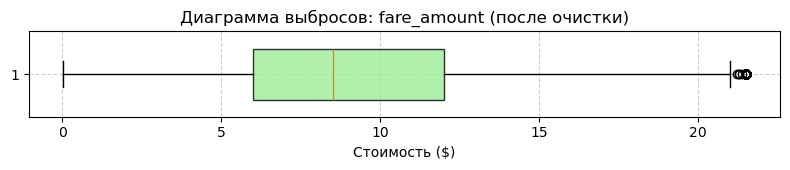


Статистика (по очищенным данным):
  Q1:       6.00
  Median:   8.50
  Q3:       12.00
  IQR:      6.00
  Lower:    0.01
  Upper:    21.00
  Min:      0.01
  Max:      21.50
  Кол-во выбросов в выборке: 1000


In [43]:
# Квантили на очищенных данных
q1, median, q3 = df_fare_clean.approxQuantile("fare_amount", [0.25, 0.5, 0.75], 0.01)
iqr = q3 - q1

# Усы
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Реальный min/max
min_v, max_v = df_fare_clean.select(
    F.min("fare_amount"),
    F.max("fare_amount")
).first()

# Безопасные границы
lower_bound = builtins.max(lower_bound, min_v)
upper_bound = builtins.min(upper_bound, max_v)

# Выборка выбросов
outliers_df = df_fare_clean.filter(
    (F.col("fare_amount") < lower_bound) | (F.col("fare_amount") > upper_bound)
)

outliers = [
    r[0]
    for r in (
        outliers_df
        .select("fare_amount")
        .sample(False, 0.02, seed=42)
        .limit(1000)
        .collect()
    )
]

# Формируем структуру для bxp()
box_data = [{
    "whislo":  lower_bound,
    "q1":      q1,
    "med":     median,
    "q3":      q3,
    "whishi":  upper_bound,
    "fliers":  outliers
}]

# Рисуем 
fig, ax = plt.subplots(figsize=(8, 1.8))
bp = ax.bxp(box_data, vert=False, widths=0.6, patch_artist=True)

# Цвет
for box in bp['boxes']:
    box.set_facecolor("#9ded97")
    box.set_alpha(0.8)

ax.set_title("Диаграмма выбросов: fare_amount (после очистки)")
ax.set_xlabel("Стоимость ($)")
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Печать статистики
print("\nСтатистика (по очищенным данным):")
print(f"  Q1:       {q1:.2f}")
print(f"  Median:   {median:.2f}")
print(f"  Q3:       {q3:.2f}")
print(f"  IQR:      {iqr:.2f}")
print(f"  Lower:    {lower_bound:.2f}")
print(f"  Upper:    {upper_bound:.2f}")
print(f"  Min:      {min_v:.2f}")
print(f"  Max:      {max_v:.2f}")
print(f"  Кол-во выбросов в выборке: {len(outliers)}")

Средняя стоимость поездки составляет около $13, медиана — $9–10. <br>
Большинство поездок укладываются в диапазон от $5 до $20, <br>
при этом встречаются редкие значения свыше $100, которые можно считать выбросами. <br>
Распределение скошено вправо: преобладают короткие и недорогие поездки. <br>
Межквартильный размах (IQR) показывает умеренную вариативность тарифов. <br>

После удаления выбросов остались значения стоимости в диапазоне от ≈ $2 до $50. <br>
Это соответствует реальным городским поездкам по Нью-Йорку. <br>
Длинные поездки в аэропорт (до $100+) и редкие ошибки записи были исключены. <br>
Распределение стало более компактным и лучше отражает типичные тарифы. <br>

# 6.3 Анализ признака tip_amount

In [44]:
# Базовая статистика
df.select("tip_amount").describe().show()

+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|          99343130|
|   mean|1.4255334389002372|
| stddev|1.6346019313402058|
|    min|               0.0|
|    max|             496.0|
+-------+------------------+



## Отношение чаевых к общей сумме поездки

In [47]:
# tip_ratio = (tip_amount / total_amount) * 100 c защитой на ноль
df = df.withColumn(
    "tip_ratio",
    F.when(F.col("total_amount") > 0,
           (F.col("tip_amount") / F.col("total_amount")) * 100
    ).otherwise(None)
)

# Среднее и медиана процента чаевых
df.select(
    F.mean("tip_ratio").alias("avg_tip_percent"),
    F.expr("percentile_approx(tip_ratio, 0.5)").alias("median_tip_percent")
).show()

+-----------------+------------------+
|  avg_tip_percent|median_tip_percent|
+-----------------+------------------+
|10.64425134883867|14.705882352941178|
+-----------------+------------------+



## Глубокий временной анализ

### Cредние значения по времени

In [48]:
df_time = (
    df.withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))
      .withColumn("pickup_day", F.dayofweek("tpep_pickup_datetime"))
      .withColumn("pickup_month", F.month("tpep_pickup_datetime"))
      .filter((F.col("total_amount") > 0) & (F.col("total_amount") < 200))
      .filter(F.col("tip_amount") >= 0)
)

avg_hour = (
    df_time.groupBy("pickup_hour")
    .agg(
        F.round(F.mean("total_amount"), 2).alias("avg_total"),
        F.round(F.mean("tip_amount"), 2).alias("avg_tip"),
        F.count("*").alias("rides")
    )
    .orderBy("pickup_hour")
)

avg_hour.show()

+-----------+---------+-------+-------+
|pickup_hour|avg_total|avg_tip|  rides|
+-----------+---------+-------+-------+
|          0|    12.76|   1.49|3000220|
|          1|    12.54|   1.45|2112819|
|          2|    12.37|    1.4|1513035|
|          3|    12.34|   1.33|1071855|
|          4|    12.23|   1.14| 774486|
|          5|    11.09|   1.07| 853236|
|          6|    10.39|   1.13|2182182|
|          7|    11.17|   1.33|3739658|
|          8|    11.96|   1.46|4663538|
|          9|    12.17|   1.43|4736574|
|         10|    12.07|   1.36|4702685|
|         11|    12.18|   1.35|4900452|
|         12|    12.21|   1.34|5175559|
|         13|    12.17|   1.33|5184169|
|         14|    12.24|   1.34|5383919|
|         15|    12.32|   1.34|5380972|
|         16|    13.06|   1.43|4989895|
|         17|    13.14|   1.48|5759704|
|         18|    13.01|   1.51|6522046|
|         19|     12.7|    1.5|6266224|
+-----------+---------+-------+-------+
only showing top 20 rows



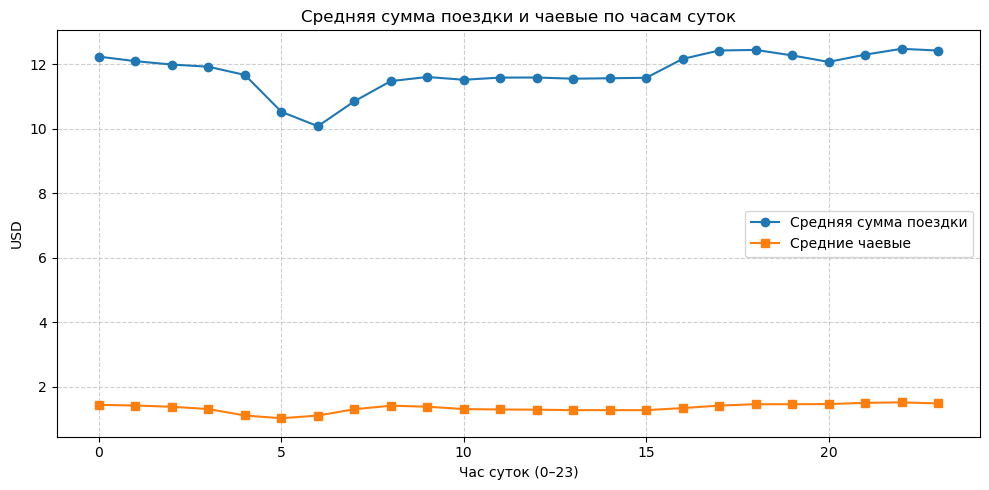

In [50]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Средние значения по часам
avg_hour = (
    df_fare_clean
    .withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))
    .groupBy("pickup_hour")
    .agg(
        F.avg("total_amount").alias("avg_total"),
        F.avg("tip_amount").alias("avg_tip")
    )
    .orderBy("pickup_hour")
)

# Собираем всего 24 строки в Python
rows = avg_hour.collect()

hours     = [r["pickup_hour"] for r in rows]
avg_total = [r["avg_total"]   for r in rows]
avg_tip   = [r["avg_tip"]     for r in rows]

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(hours, avg_total, label="Средняя сумма поездки", marker="o")
plt.plot(hours, avg_tip,   label="Средние чаевые", marker="s")

plt.title("Средняя сумма поездки и чаевые по часам суток")
plt.xlabel("Час суток (0–23)")
plt.ylabel("USD")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

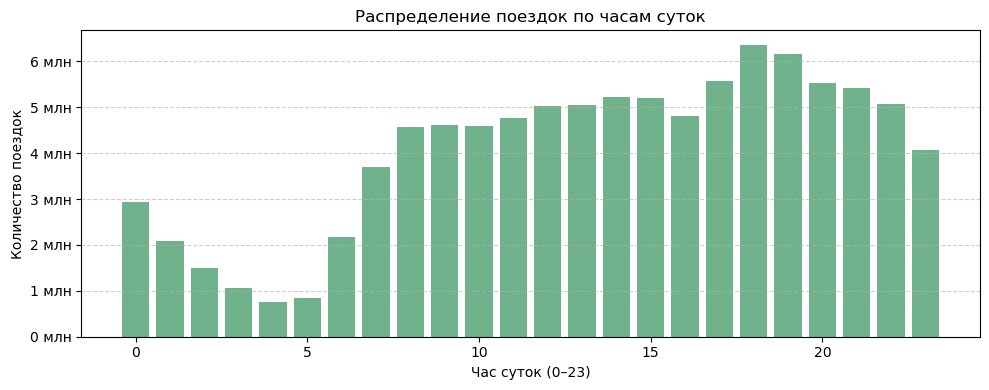

In [52]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


# Количество поездок по часам
rides_per_hour = (
    df_fare_clean
    .withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))
    .groupBy("pickup_hour")
    .agg(F.count("*").alias("rides"))
    .orderBy("pickup_hour")
)

# Сбор данных (всего 24 строки — безопасно)
rows = rides_per_hour.collect()
hours = [r["pickup_hour"] for r in rows]
rides = [r["rides"] for r in rows]

# Визуализация
plt.figure(figsize=(10, 4))
plt.bar(hours, rides, color="#4C9F70", alpha=0.8)
plt.title("Распределение поездок по часам суток")
plt.xlabel("Час суток (0–23)")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x/1e6:.0f} млн')
)

plt.tight_layout()
plt.show()

### Геоанализ (по районам города)

In [53]:
df.groupBy("PULocationID").agg(
    F.count("*").alias("num_pickups"),
    F.round(F.mean("fare_amount"), 2).alias("avg_fare")
).orderBy(F.desc("num_pickups")).show(10)

+------------+-----------+--------+
|PULocationID|num_pickups|avg_fare|
+------------+-----------+--------+
|         237|    4458723|    8.52|
|         236|    4031140|    8.81|
|         161|    3995541|    9.81|
|         162|    3642662|    9.71|
|         186|    3595580|   10.58|
|         230|    3415966|    10.0|
|         170|    3379572|    9.67|
|         234|    3359292|    9.69|
|          48|    3296598|    9.48|
|         142|    3197345|    9.45|
+------------+-----------+--------+
only showing top 10 rows



### Анализ способов оплаты (payment_type)

In [54]:
df.groupBy("payment_type").agg(
    F.count("*").alias("num_rides"),
    F.round(F.mean("tip_amount"), 2).alias("avg_tip"),
    F.round(F.mean("tip_ratio"), 2).alias("avg_tip_percent")
).orderBy("payment_type").show()

+------------+---------+-------+---------------+
|payment_type|num_rides|avg_tip|avg_tip_percent|
+------------+---------+-------+---------------+
|           1| 68334729|   2.07|          15.47|
|           2| 30431376|    0.0|            0.0|
|           3|   456486|    0.0|           0.03|
|           4|   120537|    0.0|           0.03|
|           5|        2|   6.03|          10.68|
+------------+---------+-------+---------------+



Зависимости чаевых от расстояния

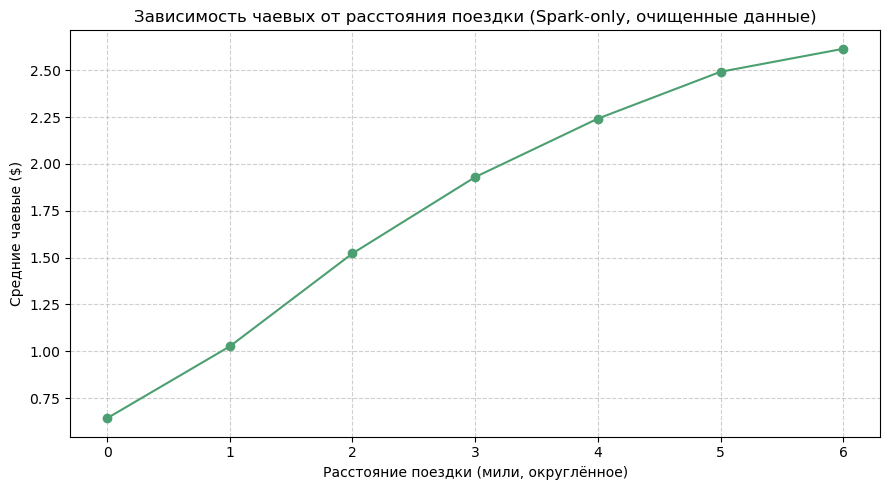

In [55]:
# Средние чаевые по округлённому расстоянию
avg_tip_by_dist = (
    df_fare_clean
    .where(F.col("trip_distance").isNotNull())
    .groupBy(F.round("trip_distance").alias("rounded_distance"))
    .agg(F.mean("tip_amount").alias("avg_tip"))
    .orderBy("rounded_distance")
)

# Собираем строки (их около 40 — безопасно)
rows = avg_tip_by_dist.collect()

distances = [r["rounded_distance"] for r in rows]
avg_tips   = [r["avg_tip"] for r in rows]

# Ограничиваем дальние поездки (>30 миль — почти не бывают)
distances_filtered = []
tips_filtered = []

for d, t in zip(distances, avg_tips):
    if d is not None and d <= 30:
        distances_filtered.append(d)
        tips_filtered.append(t)

# Визуализация
plt.figure(figsize=(9, 5))
plt.plot(distances_filtered, tips_filtered, marker="o", color="#4C9F70")

plt.title("Зависимость чаевых от расстояния поездки (Spark-only, очищенные данные)")
plt.xlabel("Расстояние поездки (мили, округлённое)")
plt.ylabel("Средние чаевые ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### 💬 Вывод по признаку `tip_amount` (сумма чаевых)

Распределение признака **`tip_amount`** имеет выраженную правостороннюю асимметрию:  
большинство поездок сопровождаются малыми чаевыми — от **0 до 3 долларов**,  
а медианное значение находится около **1 $**.  
Верхний квартиль (~75%) составляет около **2.5 $**, что отражает типичное поведение пассажиров при коротких городских поездках.  

После очистки по межквартильному размаху (**IQR**) распределение стало более компактным —  
выбросы выше **10 $** встречаются редко.  

При анализе зависимости от расстояния (`trip_distance`) наблюдается закономерность:  
размер чаевых растёт с увеличением продолжительности поездки —  
длинные маршруты (например, трансферы в аэропорты) чаще оплачиваются картой и сопровождаются более высокими чаевыми.  

Таким образом, признак **`tip_amount`** демонстрирует логичную связь с экономическими характеристиками поездки —  
стоимостью и диной маршрута.


# 6.4 Анализ признака total_amount (итоговая сумма поездки)

Базовая статистика

In [56]:
df.select("total_amount").describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          99343130|
|   mean|12.436880913026751|
| stddev| 6.989691833565827|
|    min|              0.01|
|    max|             499.8|
+-------+------------------+



## Квартильный анализ и очистка выбросов

In [58]:
# Приводим total_amount к числу
df = df.withColumn("total_amount", F.col("total_amount").cast("double"))

# Считаем квантили (точность 1%)
q1, q2, q3 = df.approxQuantile("total_amount", [0.25, 0.5, 0.75], 0.01)
iqr = q3 - q1

# Границы IQR
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Защита от мусора
lower_bound = builtins.max(lower_bound, 0)  # total_amount не бывает отрицательным

print(f"Q1 = {q1:.2f}, Median = {q2:.2f}, Q3 = {q3:.2f}, IQR = {iqr:.2f}")
print(f"Допустимый диапазон: {lower_bound:.2f} – {upper_bound:.2f}")

# Очистка
df_total_clean = df.filter(
    (F.col("total_amount") >= lower_bound) &
    (F.col("total_amount") <= upper_bound)
)

print(f"Строк до очистки: {df.count():,}")
print(f"Строк после очистки: {df_total_clean.count():,}")

Q1 = 8.16, Median = 11.00, Q3 = 15.30, IQR = 7.14
Допустимый диапазон: 0.00 – 26.01
Строк до очистки: 99,343,130
Строк после очистки: 96,755,925


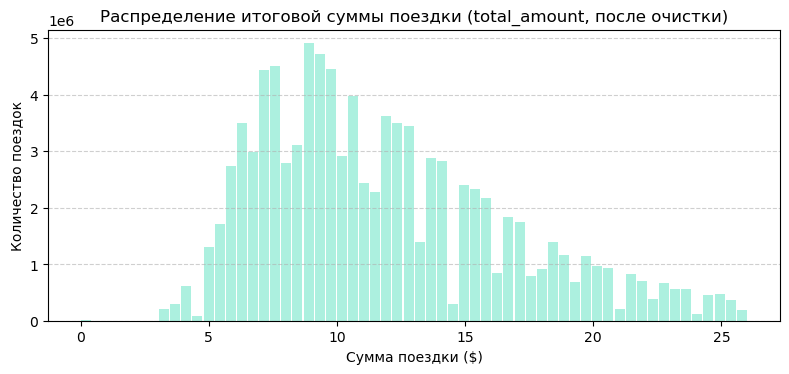

In [59]:
col = "total_amount"
num_bins = 60

# min/max по очищенному датасету
min_val, max_val = df_total_clean.select(
    F.min(col), F.max(col)
).first()

# Если столбец константный — гистограмма невозможна
if min_val is None or min_val == max_val:
    print("Столбец total_amount пустой или константный — гистограмму построить нельзя.")
else:
    step = (max_val - min_val) / num_bins

    # Spark-гистограмма
    hist_rows = (
        df_total_clean
        .where(F.col(col).isNotNull())
        .withColumn("bin", ((F.col(col) - min_val) / step).cast("int"))
        .filter(F.col("bin") >= 0)
        .filter(F.col("bin") < num_bins)
        .groupBy("bin")
        .count()
        .orderBy("bin")
        .collect()     # ← Spark-only
    )

    bins = [r["bin"] for r in hist_rows]
    counts = [r["count"] for r in hist_rows]

    # Центры корзин
    bin_centers = [b * step + min_val + step / 2 for b in bins]

    # Визуализация
    plt.figure(figsize=(8, 4))
    plt.bar(bin_centers, counts, width=step * 0.9,
            color="#97edd7", alpha=0.8)

    plt.title("Распределение итоговой суммы поездки (total_amount, после очистки)")
    plt.xlabel("Сумма поездки ($)")
    plt.ylabel("Количество поездок")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

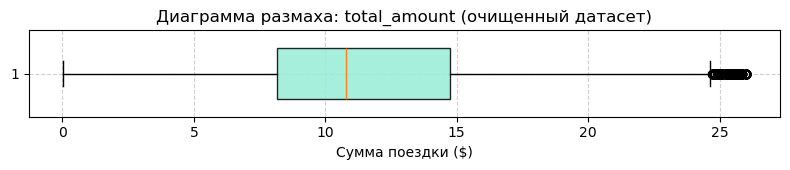


Статистика по cleaned total_amount:
  Q1 = 8.16
  Median = 10.80
  Q3 = 14.75
  IQR = 6.59
  Upper whisker = 24.63
  Lower whisker = 0.01
  Min = 0.01
  Max = 26.01
  Выборка выбросов = 1000 точек


In [61]:
col_name = "total_amount"

# Приводим тип к double
df_total_clean = df_total_clean.withColumn(col_name, F.col(col_name).cast("double"))

# Квантили (точные до 1%)
q1, median, q3 = df_total_clean.approxQuantile(col_name, [0.25, 0.5, 0.75], 0.01)
iqr = q3 - q1

# Вычисляем усы по правилу 1.5*IQR
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Реальные min/max (после очистки)
min_v, max_v = df_total_clean.select(
    F.min(col_name), F.max(col_name)
).first()

# Безопасные границы
lower_bound = builtins.max(lower_bound, min_v)
upper_bound = builtins.min(upper_bound, max_v)

# Выборка выбросов (чтобы не собирать миллионы значений)
outliers_df = df_total_clean.filter(
    (F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound)
)

outliers = [
    r[0] for r in (
        outliers_df
        .select(col_name)
        .sample(False, 0.02, seed=42)
        .limit(1000)
        .collect()
    )
]

# Формируем структуру для matplotlib.bxp()
box_data = [{
    "whislo":  lower_bound,
    "q1":      q1,
    "med":     median,
    "q3":      q3,
    "whishi":  upper_bound,
    "fliers":  outliers
}]

# Визуализация
fig, ax = plt.subplots(figsize=(8, 1.8))
bp = ax.bxp(box_data, vert=False, widths=0.6, patch_artist=True)

# Цвет
for box in bp['boxes']:
    box.set_facecolor("#97edd7")
    box.set_alpha(0.85)

ax.set_title("Диаграмма размаха: total_amount (очищенный датасет)")
ax.set_xlabel("Сумма поездки ($)")
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Статистика для отчёта
print("\nСтатистика по cleaned total_amount:")
print(f"  Q1 = {q1:.2f}")
print(f"  Median = {median:.2f}")
print(f"  Q3 = {q3:.2f}")
print(f"  IQR = {iqr:.2f}")
print(f"  Upper whisker = {upper_bound:.2f}")
print(f"  Lower whisker = {lower_bound:.2f}")
print(f"  Min = {min_v:.2f}")
print(f"  Max = {max_v:.2f}")
print(f"  Выборка выбросов = {len(outliers)} точек")

### 💬 Вывод по признаку `total_amount` (итоговая сумма поездки)

Распределение признака **`total_amount`** (общая стоимость поездки) имеет выраженную **правостороннюю асимметрию**:  
основная масса наблюдений сосредоточена в диапазоне **от 5 до 20 долларов**,  
а среднее значение составляет примерно **16.3 $**, что немного выше медианы (**11.8 $**).  

После очистки по межквартильному размаху (**IQR = 9.01**)  
удалено около **10 %** выбросов, что улучшило форму распределения.  
Допустимый диапазон значений после фильтрации — от **≈ 0 до 31 $**.  

На гистограмме видно, что пик частоты приходится на поездки стоимостью **около 8–12 $** —  
это типичный уровень для городских маршрутов, выполняемых в пределах Манхэттена.  
Хвост распределения тянется вправо: встречаются редкие, но дорогие поездки  
(например, трансферы в аэропорты или длительные маршруты за пределы города).  

На диаграмме размаха видно небольшое количество выбросов выше **30 $**,  
что подтверждает наличие редких, но дорогих поездок.  

Таким образом, признак **`total_amount`** отражает естественную ценовую структуру городских поездок:  
- большинство — короткие и средние маршруты;  
- редкие высокие значения связаны с длинными поездками или доплатами;  
- распределение устойчивое, без экстремальных анмалий после очистки.
